In [1]:
import os
import tensorflow as tf
import pandas as pd

tf.__version__


'2.13.0'

In [2]:
train_dir = r'https://raw.githubusercontent.com/sedeba19/NLP--Random-Models/main/train.csv'
test_dir = r'https://raw.githubusercontent.com/sedeba19/NLP--Random-Models/main/test.csv'

In [3]:
train_dir

'https://raw.githubusercontent.com/sedeba19/NLP--Random-Models/main/train.csv'

In [4]:
# Make a train_df
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state = 1)
train_df_shuffled.head()

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1


In [6]:
train_df_shuffled.shape

(7613, 5)

In [7]:
# How many examples of each class?
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index: random_index +5].itertuples():
    _, text, target = row
    if target > 0:
        print(f"Target:{target}", "(real disaster)")
    else:
        print(f"Target:{target}", "(not a real disaster)")
    
    print(f"Text: \n{text}")
    print("-----\n")

Target:0 (not a real disaster)
Text: 
the apocalypse is upon us
-----

Target:0 (not a real disaster)
Text: 
when you are quarantined to a little corner bc you are too sick to be in the office but work is piling up and they need you kinda day
-----

Target:0 (not a real disaster)
Text: 
just got engulfed in a car-induced tidal wave on my run... I thought this only happened in the movies ????
-----

Target:0 (not a real disaster)
Text: 
Blending the old with the new in #Vanuatu to prepare for future emergencies: 
http://t.co/aFMKcFn1TL http://t.co/8QqzYZIAqf
-----

Target:1 (real disaster)
Text: 
#INCIDENT
Crash in Pascoe Vale South outbound on Tullamarine Fwy (CityLink) near Moreland Rd. Vehicles off in emergency lane. No delays.
-----


### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df['text'],
                                                                            train_df['target'],
                                                                            test_size = 0.1,
                                                                            random_state = 42)

In [11]:
train_df['text'].shape

(7613,)

In [12]:
train_df["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [13]:
train_df['text'].to_numpy()

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [14]:
train_df['text'].to_numpy()

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [15]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

### Converting text into numbers: Text Vectorization also known as Tokenization

In [16]:
# Get the total words
total_words = 0
for i in train_sentences:
    total_words += len(i.split())

total_words

101905

In [17]:
train_sentences.shape

(6851,)

In [18]:
# Get the average words per sentence or line
avg_words_per_sentence = round(total_words/len(train_sentences))
avg_words_per_sentence

15

In [19]:
# Normally, total number of words is equal or less than the max vocabulary length
max_vocab_length = 10000

# max length of a statement is equal or more than the average word per sentence or line
max_length = 15

In [20]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a sample sentence and tokenize it
samp_sentence = "There's a flood in my street!"
print(samp_sentence, f"Sentence length is {len(samp_sentence)}.")
text_vectorizer([samp_sentence])
#len(tf.squeeze(text_vectorizer([samp_sentence])))

There's a flood in my street! Sentence length is 29.


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[282,   3, 206,   4,  13, 674,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [22]:
# Choose random sentence from the training dataset and tokenize it
rand_train_sentence = random.choice(train_sentences)
print(f"Original text: \n\n {rand_train_sentence} \n\nVectorized text:")
text_vectorizer([rand_train_sentence])

Original text: 

 Imagine having KP AND Root.... We'd demolish everyone 

Vectorized text:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1517,  600,    1,    7, 1781, 1737,  555,  232,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [23]:
# Get unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'with',
 'it',
 'that',
 'at',
 'by',
 'this',
 'from',
 'are',
 'be',
 'was',
 'have',
 'like',
 'as',
 'me',
 'but',
 'up',
 'just',
 'so',
 'im',
 'not',
 'amp',
 'your',
 'out',
 'all',
 'after',
 'its',
 'has',
 'no',
 'will',
 'an',
 'fire',
 'when',
 'if',
 'we',
 'get',
 'now',
 'more',
 'via',
 'new',
 'about',
 'what',
 'people',
 'or',
 'news',
 'he',
 'they',
 'over',
 'one',
 'been',
 'how',
 'dont',
 'who',
 'video',
 'into',
 'were',
 'do',
 'us',
 'can',
 'emergency',
 '2',
 'disaster',
 'there',
 'her',
 'some',
 'than',
 'still',
 'would',
 'his',
 'police',
 'crash',
 'burning',
 'suicide',
 'body',
 'california',
 'back',
 'time',
 'buildings',
 'had',
 'why',
 'off',
 'them',
 'got',
 'man',
 'see',
 'storm',
 'know',
 'going',
 'cant',
 'world',
 'first',
 'day',
 'rt',
 'nuclear',
 'love',
 'youtube',
 'our',
 'attack',
 'go',
 'fires',
 'two',
 'their',
 'bomb',

In [24]:
len(words_in_vocab)

10000

In [25]:
# Top 5 words in words_in_vocab
words_in_vocab[:5]

['', '[UNK]', 'the', 'a', 'in']

In [26]:
# Least 5 words in words_in_vocab
words_in_vocab[-5:]

['pakthey', 'pakistan\x89Ûªs', 'pakistans', 'pajamas', 'paints']

### Embedding layer

To make our embedding, we are going to use TensorFlow’s embedding layer: https://www.tensorflow.org/api/docs/python/tf/keras/layers/

The parameters are below mostly used.
* input_dim = size of the vocabulary
* output_dim = size of the output embedding vector.  For example, a value of 100 would mean each token gets represented by a vector 100 long
* input_length = length of the sequences being passed to the embedding layer

In [27]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 64,
                             embeddings_initializer = "uniform",
                             input_length = max_length)

In [28]:
# Get a random sentence from the training set and return Original text, Vectorized text, Embedded text
rand_sentence = random.choice(train_sentences)
print(f"Original text: {rand_sentence}\n")
print(f"Vectorized text: {text_vectorizer([rand_sentence])}\n")
print(f"Vectorized text shape: {text_vectorizer([rand_sentence]).shape}")
print(f"Embbedded text: {embedding(text_vectorizer([rand_sentence]))}")
print(f"Embedded text shape: {embedding(text_vectorizer([rand_sentence])).shape}")

Original text: NIggas playing in the thunderstorm.. 'HOPE THE LORR BLESS EM' ????

Vectorized text: [[ 932  835    4    2  271  231    2    1 3136 1541    0    0    0    0
     0]]

Vectorized text shape: (1, 15)
Embbedded text: [[[ 0.03715602 -0.01391459  0.00262779 -0.03253813 -0.00725516
    0.02615971 -0.00059183  0.02832368 -0.02631495 -0.01592213
   -0.01477943  0.01858527 -0.04148604  0.01720833  0.0366033
   -0.02136395 -0.00228933  0.03821284  0.01881696 -0.02864776
    0.02872472 -0.02762547 -0.02562329  0.00920466  0.01802287
    0.02461502  0.01969132 -0.01835825  0.0096256  -0.01680189
    0.04937119  0.04793358 -0.03697328 -0.02554168  0.01966188
    0.04080832  0.02857634  0.04008815 -0.04582175 -0.0339517
    0.00289442  0.02339485 -0.02397826 -0.04779546 -0.0125935
   -0.02686766 -0.02086059  0.04140523  0.0151012   0.00170797
   -0.00478504 -0.00523517  0.00386979 -0.01616132 -0.04171702
    0.04613988 -0.04455959  0.02978333  0.03409667  0.04894798
   -0.03306695  0.

### Model_5: 1D Convolutional Neural Network (CNN)

In [29]:
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(['I am so Great!']))

conv1d_test = layers.Conv1D(filters = 32,
                            kernel_size = 5,
                            activation = 'relu',
                            padding = 'valid')
conv1d_test_output = conv1d_test(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv1d_test_output)


In [30]:
embedding_test

<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[-0.00268518,  0.02268008, -0.0496713 ,  0.00834999,
         -0.02435932,  0.02672419,  0.01920767,  0.01650462,
         -0.02841545,  0.04041788, -0.04961556, -0.00934131,
          0.00496136,  0.02447564,  0.04833757,  0.01167144,
          0.0241538 , -0.03152539,  0.0314315 , -0.03974949,
         -0.04450278, -0.02382764,  0.0055222 , -0.01151853,
         -0.0019835 , -0.04602888,  0.02249122, -0.00401648,
          0.04373914, -0.02565097, -0.04918226, -0.02428148,
          0.0440097 ,  0.03891383,  0.04004968,  0.00604117,
          0.04384411, -0.02575432, -0.01031885,  0.04045366,
         -0.03829787, -0.03943487,  0.03510375,  0.04199103,
          0.00372725, -0.03331731, -0.02826047, -0.00210855,
         -0.00484917,  0.00788695, -0.04127032, -0.04441254,
         -0.0333239 , -0.04144374, -0.04123   , -0.03882002,
         -0.02491078,  0.0161869 , -0.04569001, -0.00759248,
          0.01054465,  0.0111514

In [31]:
conv1d_test_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[9.38210934e-02, 2.12198868e-02, 5.92120271e-03, 0.00000000e+00,
         6.63743243e-02, 3.78171429e-02, 6.37993515e-02, 0.00000000e+00,
         6.79340661e-02, 0.00000000e+00, 3.83020118e-02, 3.61671224e-02,
         1.53474584e-02, 0.00000000e+00, 0.00000000e+00, 1.76949371e-02,
         6.63331822e-02, 7.87780434e-03, 0.00000000e+00, 0.00000000e+00,
         5.22941910e-03, 0.00000000e+00, 1.75168198e-02, 2.57000197e-02,
         2.59694811e-02, 1.48759428e-02, 8.45104363e-03, 5.76069541e-02,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.03656811e-02, 3.11961807e-02,
         5.64724803e-02, 8.07816684e-02, 4.17626649e-03, 0.00000000e+00,
         0.00000000e+00, 6.52557760e-02, 1.38374213e-02, 2.00060960e-02,
         0.00000000e+00, 8.49308074e-03, 0.00000000e+00, 0.00000000e+00,
         2.72892006e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+0

In [32]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.09382109, 0.03595503, 0.04036568, 0.03119618, 0.07184739,
        0.08078167, 0.06379935, 0.03297176, 0.06793407, 0.06525578,
        0.03830201, 0.05867182, 0.01534746, 0.05019183, 0.00397055,
        0.01769494, 0.06633318, 0.0078778 , 0.        , 0.        ,
        0.01472267, 0.        , 0.01751682, 0.0902755 , 0.06757585,
        0.01487594, 0.06199396, 0.07738427, 0.01773737, 0.03554225,
        0.        , 0.02713988]], dtype=float32)>

In [33]:
embedding_test.shape, conv1d_test_output.shape, max_pool_output.shape

(TensorShape([1, 15, 64]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [34]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64,
                  kernel_size = 5,
                  strides = 1,
                  activation = 'relu',
                  padding = 'valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_conv1d')

# Compile the model
model_5.compile(loss = 'binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [35]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 2s 6ms/step - loss: 0.5687 - accuracy: 0.7125 - val_loss: 0.4801 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3474 - accuracy: 0.8565 - val_loss: 0.4936 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2211 - accuracy: 0.9213 - val_loss: 0.5744 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1455 - accuracy: 0.9511 - val_loss: 0.6683 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.1019 - accuracy: 0.9661 - val_loss: 0.7396 - val_accuracy: 0.7585


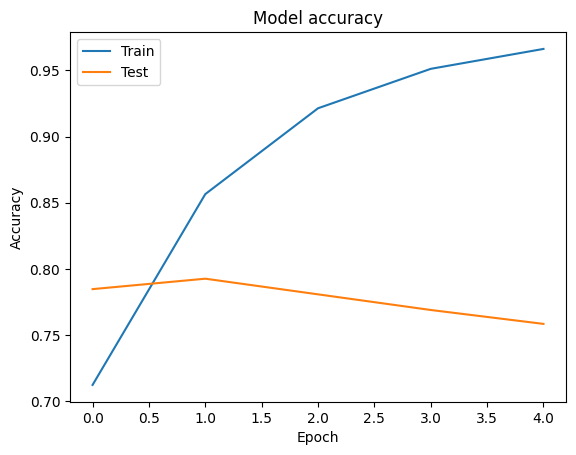

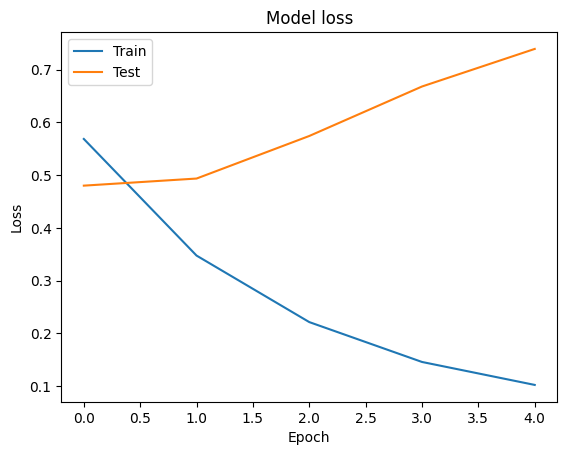

In [36]:
import matplotlib.pyplot as plt

plt.plot(model_5_history.history['accuracy'])
plt.plot(model_5_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_5_history.history['loss'])
plt.plot(model_5_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
# Make some predictions with our model_5 Conv1D
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs

24/24 [==============================] - 0s 930us/step


array([[5.99577511e-03],
       [1.32547617e-01],
       [3.06891706e-02],
       [2.48900484e-02],
       [8.58242437e-02],
       [9.96638685e-02],
       [7.05910427e-03],
       [2.84496341e-02],
       [1.51338913e-02],
       [9.98698890e-01],
       [9.63123798e-01],
       [2.40630329e-01],
       [2.16832682e-02],
       [6.35025203e-02],
       [8.47367495e-02],
       [1.61247730e-01],
       [9.92033064e-01],
       [8.91631655e-03],
       [9.99983549e-01],
       [1.19911483e-03],
       [1.25021547e-01],
       [3.21683526e-01],
       [5.77213317e-02],
       [4.60722685e-01],
       [6.12263680e-01],
       [5.44637349e-03],
       [9.99233723e-01],
       [9.21885669e-01],
       [9.99967039e-01],
       [7.05166894e-04],
       [1.90229882e-02],
       [9.83633101e-04],
       [8.90172362e-01],
       [7.66827226e-01],
       [5.50078452e-01],
       [8.70775700e-01],
       [1.09851450e-01],
       [1.67611819e-02],
       [4.94794222e-04],
       [6.54350817e-02],


In [38]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

In [39]:
# Evaluate the model by comparing the model_5_preds to val_labels
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model_5_accuracy_score = accuracy_score(val_labels, model_5_preds)
model_5_precision, model_5_recall, model_5_fscore, _ =precision_recall_fscore_support(val_labels,
                                                                                      model_5_preds, average="weighted")

In [40]:
dict_result = {"model_5_accuracy_score": model_5_accuracy_score,
               "model_5_precision": model_5_precision,
               "model_5_recall": {model_5_recall},
               "model_5_f1score": {model_5_fscore}}
dict_result

{'model_5_accuracy_score': 0.7585301837270341,
 'model_5_precision': 0.758243822059271,
 'model_5_recall': {0.7585301837270341},
 'model_5_f1score': {0.7564486801890344}}